In [1]:
import numpy as np
try:  
    import cupy as xp  
    USE_GPU = True 
except ImportError:  
    import numpy as xp 
    print('No Cupy')
    USE_GPU = False 

import matplotlib.pyplot as plt
from tqdm import tqdm

# to mute the warnings of lal 
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import * 
from Triangle.GW import * 
from Triangle.TDI import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

np.random.seed(114514)
xp.random.seed(114514)



No Cupy


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy
no BBHx waveform


## Initialize time-domain injection 

In [3]:
Tobs = 15. * DAY 
dt = 10. 
tcb_times = np.arange(int(Tobs / dt)) * dt
Tobs = len(tcb_times) * dt   

# orbit model 
ORBIT_DIR = '/home/ps/workspace/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB'
orbit = Orbit(OrbitDir=ORBIT_DIR)

# generator for the unprojected waveforms. for HM waveform, the consistency can be validated with a mode-by-mode manner. 
mbhb_waveform_generator = MBHB_Injection(approx_method="IMRPhenomD")

# use Michelson-AET channels 
A2_string, E2_string, T2_string = TDIStringManipulation.AETStringsfromXString(GeneralTDIResponse.X2_strings)

# initialize TDI response 
A2_response_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=A2_string, 
    tcb_times=tcb_times, 
    use_gpu=False, 
    drop_points=int(1000/dt), # drop 100s at the beginning and end to avoid the invalid data caused by TDI calculation 
    linear_interp=False  
    )
E2_response_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=E2_string, 
    tcb_times=tcb_times, 
    use_gpu=False, 
    drop_points=int(1000/dt), # drop 100s at the beginning and end to avoid the invalid data caused by TDI calculation 
    linear_interp=False  
    )
T2_response_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=T2_string, 
    tcb_times=tcb_times, 
    use_gpu=False, 
    drop_points=int(1000/dt), # drop 100s at the beginning and end to avoid the invalid data caused by TDI calculation 
    linear_interp=False  
    )

channel_names = ["A2", "E2", "T2"]

## Simulate time-domain waveform 

In [4]:
# set source parameters 
mbhb_parameters = {
    'chirp_mass': 1e6, # [MSUN]
    'mass_ratio': 0.4719138674211496, 
    'spin_1z': -0.219017,
    'spin_2z': 0.777287,
    'coalescence_time': Tobs / DAY - 1., # [day]
    'coalescence_phase': 3.123620213369193,
    'luminosity_distance': 88470.94592236356, # [MPC]
    'inclination': 0.6928647958196155, # [rad]
    'longitude': 4.484587022801057, # [rad]
    'latitude': 0.9023185939708002, # [rad]
    'psi': 2.050979301490759 # [rad]
    }

td_waveform = np.array([
    A2_response_generator(parameters=mbhb_parameters, waveform_generator=mbhb_waveform_generator), 
    E2_response_generator(parameters=mbhb_parameters, waveform_generator=mbhb_waveform_generator), 
    T2_response_generator(parameters=mbhb_parameters, waveform_generator=mbhb_waveform_generator), 
])

(13.97, 14.03)

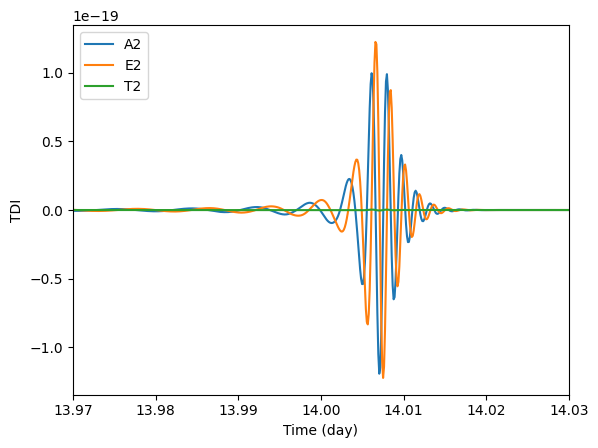

In [5]:
for ich, nch in enumerate(channel_names):
    plt.plot(tcb_times/DAY, td_waveform[ich], label=nch)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper left")
plt.xlim(mbhb_parameters["coalescence_time"] - 0.03, mbhb_parameters["coalescence_time"] + 0.03)

## Fourier transform 

In [6]:
fd_waveform_from_td = [] 
for i in range(td_waveform.shape[0]): 
    ff, xf = FFT_window(td_waveform[i], 1./dt)
    fd_waveform_from_td.append(xf)
fd_waveform_from_td = np.array(fd_waveform_from_td)

frequencies = ff 

(1e-25, 7.645953332439078e-17)

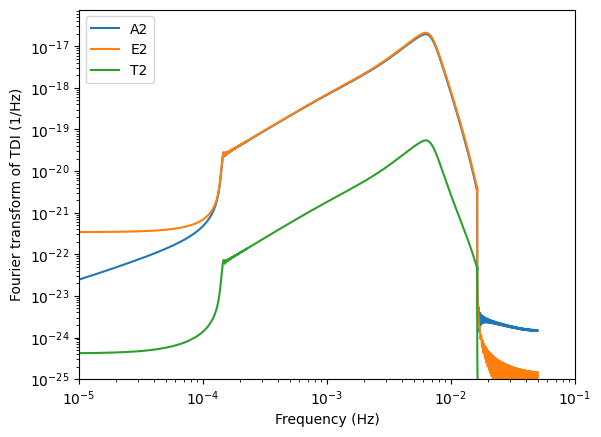

In [7]:
for ich, nch in enumerate(channel_names):
    plt.loglog(frequencies, np.abs(fd_waveform_from_td[ich]), label=nch)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transform of TDI (1/Hz)")
plt.legend(loc="upper left")
plt.xlim(1e-5, 0.1)
plt.ylim(1e-25,)

## Initialize frequency-domain template 

In [8]:
# initialize  waveform generator. we use the PhenomD waveform of WF4PY this time, and that of BBHx can be tested simillarly 
WFG = WaveformGenerator(mode="primary")

# initialize response generator 
FDTDI = FDTDIResponseGenerator(orbit_class=orbit, waveform_generator=WFG)

# response settings 
response_kwargs = dict(
    modes=[(2,2)], 
    tmin=tcb_times[0] / DAY,
    tmax=tcb_times[-1] / DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
)


## Generate frequency-domain template 

In [9]:
fd_waveform = FDTDI.Response(
    parameters=mbhb_parameters, 
    freqs=frequencies,  
    **response_kwargs, 
)

fd_waveform_from_td.shape, fd_waveform.shape 

((3, 64800), (3, 64800))

The amplitudes match well, but the phases generally donot match due to the difference between the implementations of Phenom waveform in different softwares. Perfect match can be achieved after optimizing over $\{t_c, \varphi_c\}$.

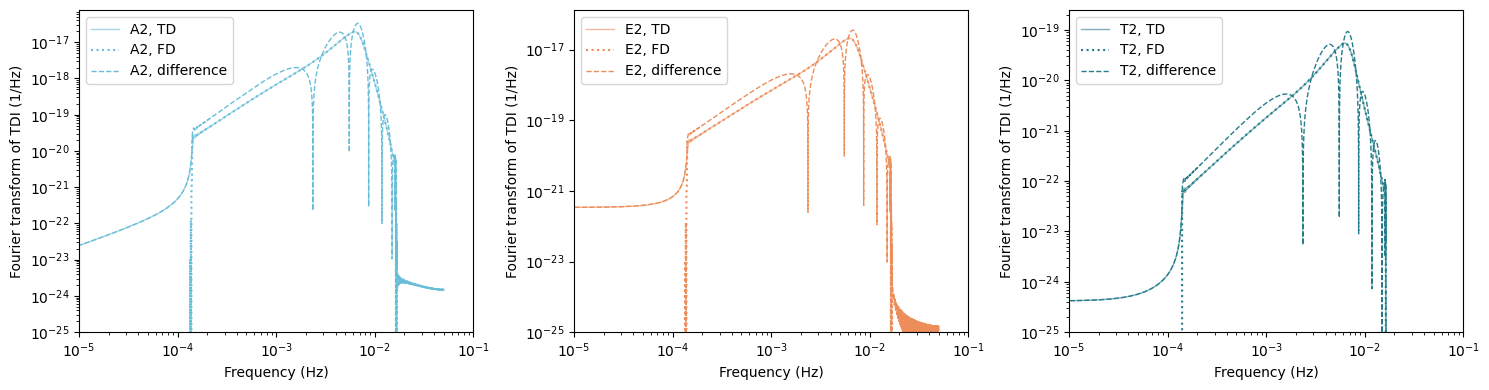

In [11]:
plt.figure(figsize=(15, 4))
for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, GREEN1]):
    plt.subplot(131+ich)
    plt.loglog(frequencies, np.abs(fd_waveform_from_td[ich]), label=nch+", TD", color=cch, linewidth=1, alpha=0.6)
    plt.loglog(frequencies, np.abs(fd_waveform[ich]), label=nch+", FD", color=cch, linestyle=":")
    plt.loglog(frequencies, np.abs(fd_waveform_from_td[ich] - fd_waveform[ich]), label=nch+", difference", color=cch, linestyle="--", linewidth=1)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Fourier transform of TDI (1/Hz)")
    plt.legend(loc="upper left")
    plt.xlim(1e-5, 0.1)
    plt.ylim(1e-25,)
plt.tight_layout()

## Optimize 

In [12]:
PSDfunc = TDIPSDs() 
PSDdata = (PSDfunc.PSD_A2(frequencies))

def cost_function(param2d): 
    p = mbhb_parameters.copy() 
    p["coalescence_time"] = param2d[0]
    p["coalescence_phase"] = param2d[1]
    # p["psi"] = param2d[2]
    tmp = FDTDI.Response(p, frequencies, **response_kwargs)[:2] # use AE 
    return np.sum(np.abs(tmp - fd_waveform_from_td[:2]) ** 2 / PSDdata)

In [13]:
from scipy.optimize import differential_evolution

result = differential_evolution(
    cost_function, 
    bounds=[(mbhb_parameters["coalescence_time"] - 1e-2, mbhb_parameters["coalescence_time"] + 1e-2), (0, TWOPI)],
    strategy='best1bin',    
    maxiter=5000,
    popsize=15,
    tol=1e-5, 
    mutation=(0.5, 1),    
    recombination=0.9, 
    workers=-1, 
    updating='deferred', 
    seed=42
)

print("differences between injection and optimized parameters:")
print("tc:", result.x[0] - mbhb_parameters["coalescence_time"])
print("phic:", result.x[1] - mbhb_parameters["coalescence_phase"])

differences between injection and optimized parameters:
tc: 0.0036706094115324106
phic: 0.791448732233782


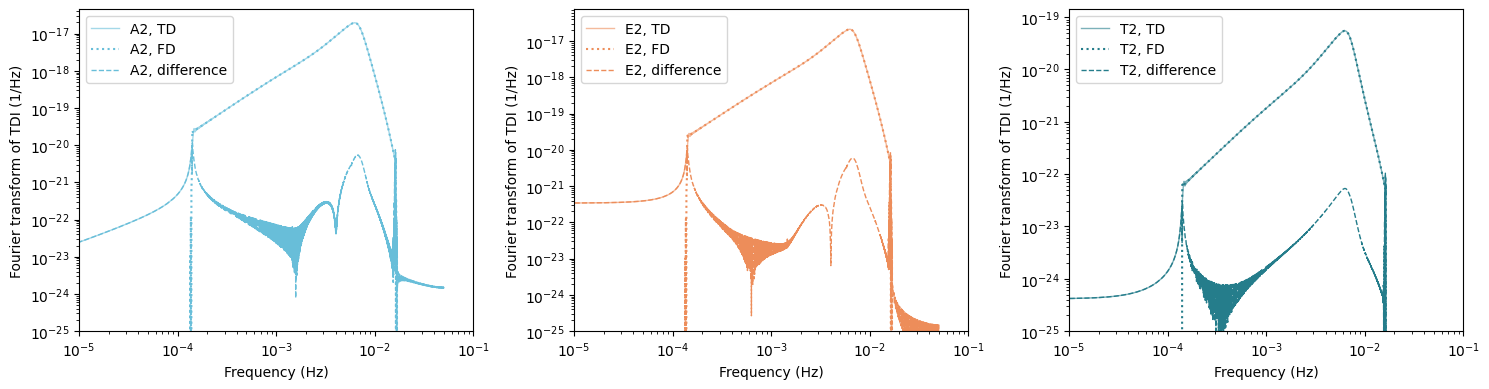

In [15]:
mbhb_parameters_opt = mbhb_parameters.copy()
mbhb_parameters_opt["coalescence_time"] = result.x[0]
mbhb_parameters_opt["coalescence_phase"] = result.x[1]

fd_waveform_opt = FDTDI.Response(
    parameters=mbhb_parameters_opt, 
    freqs=frequencies,  
    **response_kwargs, 
)

plt.figure(figsize=(15, 4))
for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, GREEN1]):
    plt.subplot(131+ich)
    plt.loglog(frequencies, np.abs(fd_waveform_from_td[ich]), label=nch+", TD", color=cch, linewidth=1, alpha=0.6)
    plt.loglog(frequencies, np.abs(fd_waveform_opt[ich]), label=nch+", FD", color=cch, linestyle=":")
    plt.loglog(frequencies, np.abs(fd_waveform_from_td[ich] - fd_waveform_opt[ich]), label=nch+", difference", color=cch, linestyle="--", linewidth=1)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Fourier transform of TDI (1/Hz)")
    plt.legend(loc="upper left")
    plt.xlim(1e-5, 0.1)
    plt.ylim(1e-25,)
plt.tight_layout() 